In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from SinglePhotonIO import getChannels
from cont_trigger import rand_sections_wrapper, calc_psd, OptimumFilt
from pycdms.detcal.misc.cut import autocuts
from pycdms.detcal.misc.utils import ofamp
from time import time

% matplotlib inline

/galbascratch/samwatkins/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for DataWriter already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
fpath = sorted(glob("/galbadata/Stanford/KO15/Continuous/180612_1554/180612_1554*.mat"))
# fpath = sorted(glob("/galbadata/Stanford/KO15/Continuous/180703_0825*.mat"))

f = [int(ff[60:62].replace(".","")) for ff in fpath]
filepath = [x for _,x in sorted(zip(f,fpath))]

In [3]:
start = time()

n, l = 200, 125000
t, res = rand_sections_wrapper(filepath, n, l)
print(time()-start)


134.26350331306458


In [4]:
pt = res.sum(axis=1)
cut = autocuts(pt, fs=1.25e6)
f, psd = calc_psd(pt[cut], fs=1.25e6, folded_over=False)

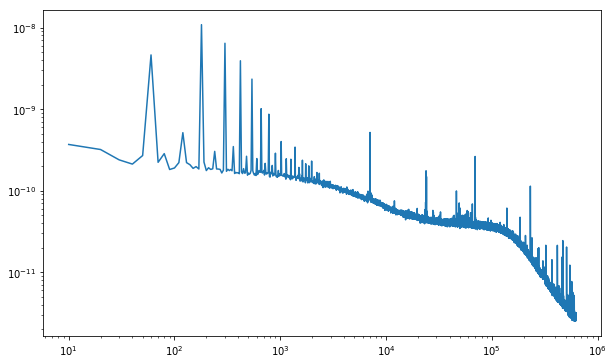

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(f[f>0],np.sqrt(2*psd[f>0]))
ax.set_yscale("log")
ax.set_xscale("log")

In [6]:
fs = 1.25e6
tracelength = 125000
# Dummy pulse template
nbin = len(psd)
ind_trigger = round(nbin/2)
timess = 1.0/fs *(np.arange(1,nbin+1)-ind_trigger)
lgc_b0= timess < 0.0

# pulse shape
tau_risepulse= 20.0e-6
tau_fallpulse= 80.0e-6
testTemplate = (1.0-np.exp(-timess/tau_risepulse))*np.exp(-timess/tau_fallpulse)
testTemplate[lgc_b0]=0.0
testTemplate = testTemplate/max(testTemplate)

In [7]:
triglen = 64
ttltime = 8e-6 # length of ttl pulse in seconds
ttllen = int(ttltime*fs)
ind_trigger = round(triglen/2)

trigtemplate = np.zeros(triglen)
trigtemplate[ind_trigger:ind_trigger+ttllen] = 1

In [8]:
start = time()

pulses = getChannels(filepath[0])
fs = pulses["prop"]["sample_rate"][0][0][0][0]
traces = np.stack((pulses["A"], pulses["B"]), axis=1)/1024
trig = pulses["T"]*1e6/1024
times = pulses["time"]

print(time()-start)

2.1374576091766357


In [9]:
if len(trig)==0:
    OF = OptimumFilt(fs, testTemplate, psd, tracelength)
    OF.filtertraces(traces, times)
    OF.eventtrigger(4, positivepulses=False)
else:
    OF = OptimumFilt(fs, testTemplate, psd, tracelength, trigtemplate=trigtemplate)
    OF.filtertraces(traces, times, trig = trig)
    OF.eventtrigger(4, trigthresh=0.8)